In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# ========== 1. 读取数据 ==========
df = pd.read_csv('data_processed_std.csv')



y_col = 'Y染色体浓度'
x_cols = ['检测孕周_周数','年龄','孕妇BMI','IVF妊娠','怀孕次数','生产次数']

# ========== 3. 调整 y 到 (0,1) ==========
eps = 1e-6
df['y_adj'] = df[y_col].clip(lower=eps, upper=1 - eps)

# ========== 4. 定义 logit / inv_logit ==========
def logit(p):
    return np.log(p / (1 - p))

def inv_logit(z):
    return 1 / (1 + np.exp(-z))

# ========== 5. 交叉验证 ==========
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mae_scores = [], []

for train_idx, test_idx in kf.split(df):
    train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
    
    X_train, X_test = train_df[x_cols], test_df[x_cols]
    y_train_logit = logit(train_df['y_adj'])
    
    # XGBoost 回归器
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.04,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42
    )
    model.fit(X_train, y_train_logit)
    
    # 预测并反变换
    y_pred_logit = model.predict(X_test)
    y_pred = inv_logit(y_pred_logit)
    
    # 评估
    r2_scores.append(r2_score(test_df['y_adj'], y_pred))
    mae_scores.append(mean_absolute_error(test_df['y_adj'], y_pred))

print(f"XGBoost-Beta 平均 R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"XGBoost-Beta 平均 MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

# ========== 6. 最终模型（全数据） ==========
y_logit_full = logit(df['y_adj'])
final_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)
final_model.fit(df[x_cols], y_logit_full)

# 保存模型
import joblib
joblib.dump(final_model, 'xgb_beta_model.pkl')
print("最终模型已保存：xgb_beta_model.pkl")


XGBoost-Beta 平均 R²: 0.1082 ± 0.1041
XGBoost-Beta 平均 MAE: 0.0234 ± 0.0020
最终模型已保存：xgb_beta_model.pkl


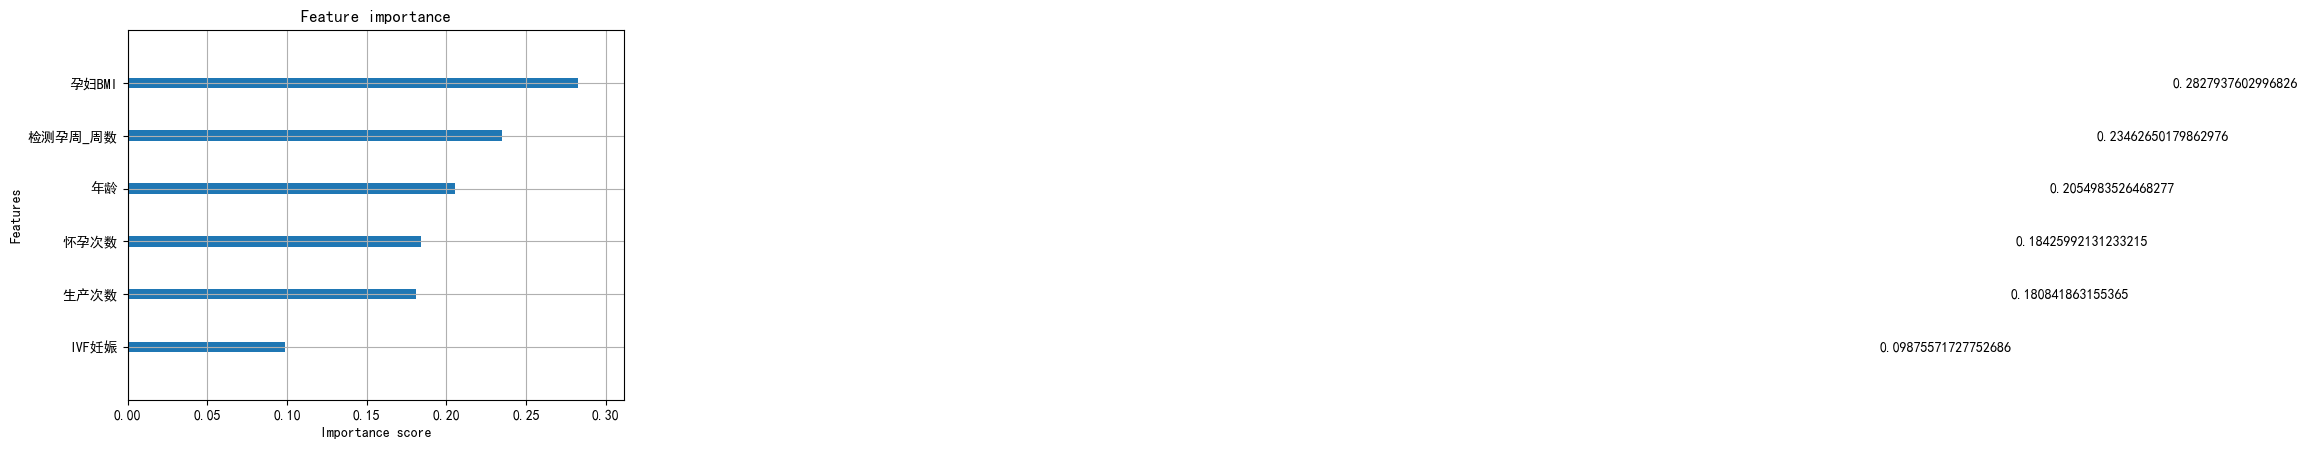

In [3]:
from xgboost import plot_importance


# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

plot_importance(final_model, importance_type='gain')
plt.show()
